<center>
    <h1>Probabilistic Model Checking with Stormpy</h1>
    <h2>Sebastian Junges</h2>
    <h3>Slides by Matthias Volk</h3>
    <br>
    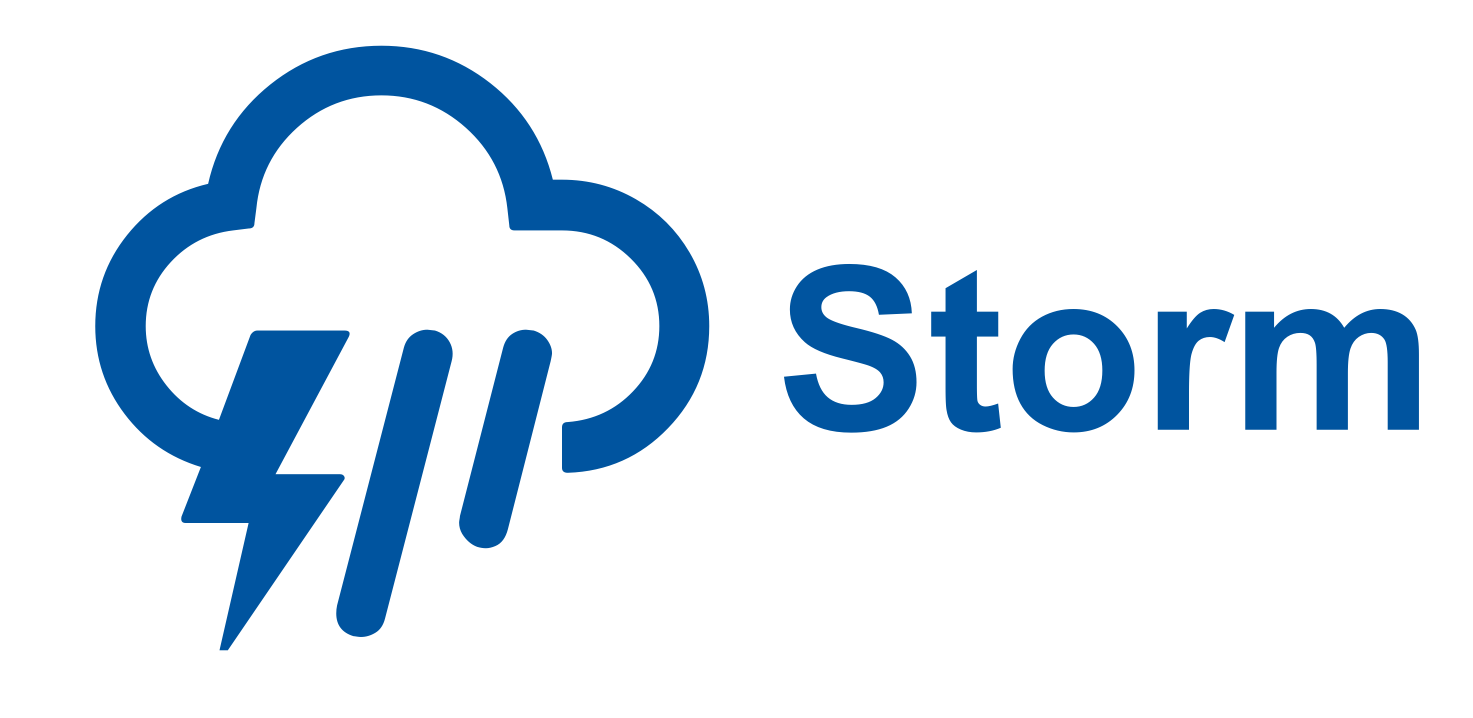
</center>

**<center>[www.stormchecker.org](https://www.stormchecker.org)</center>**

<div align="right">Press <em>spacebar</em> to navigate</div>

## Stormpy
### Python bindings for Storm
- **Easy access** to Storm's algorithms and features
- Maintains **performance** of Storm
- Allows **rapid prototyping**:  
  &#10140; Implement your own customized approach  based on probabilistic model checking

more information at:
**<center>[www.stormchecker.org/stormpy/](https://www.stormchecker.org/stormpy/)</center>**



## Running Stormpy


In [2]:
import stormpy
import stormpy.info

print("Stormpy version: " + stormpy.__version__)
print("using Storm in version: " + stormpy.info.storm_version())

Stormpy version: 1.9.0
using Storm in version: 1.9.0


## Running example: MP3 player
<br>
<center>
    
<div style="font-size:10px">Source: <a href="https://pixabay.com/vectors/mp3-player-mp3-usb-player-music-146314/">Pixabay</a></div>
</center>

### Setting:
- MP3 Player with 100 songs
- Start at random song
- Want to listen to song number 42
- Only two buttons:
  - *next song*
  - *random song*

### Question:
- Find fewest steps to reach song number 42
- Which buttons should be pressed in which order?

## Music shuffle in stormpy


In [3]:
prism_program = stormpy.parse_prism_program("examples/music_shuffle.nm")
print(prism_program.model_type)

ERROR (file.h:39): Could not open file examples/music_shuffle.nm.


RuntimeError: FileIoException: Could not open file examples/music_shuffle.nm.

In [ ]:
options = stormpy.BuilderOptions(True, True)
options.set_build_state_valuations()
options.set_build_choice_labels()
model = stormpy.build_sparse_model_with_options(prism_program, options)
print("Number of states: {}".format(model.nr_states))
print("Number of transitions: {}".format(model.nr_transitions))
print("Labels: {}".format(model.labeling.get_labels()))

## Model checking with stormpy


In [5]:
# Set property
formula_str = 'Rmin=? [F "found"]'
properties = stormpy.parse_properties(formula_str, prism_program)

# Model checking
result = stormpy.model_checking(model, properties[0])

# Print result
initial_state = model.initial_states[0]
print("Expected number of steps to reach song 42 (from initial state): {}".format(result.at(initial_state)))

Expected number of steps to reach song 42 (from initial state): 12.642880448519971


## Exploring the model

In [6]:
state = model.states[2]
state_vals = model.state_valuations
print("State {} with variable values: {}".format(state, state_vals.get_string(state.id)))
choice_labels = model.choice_labeling
for action in state.actions:
    for transition in action.transitions:
        print("With action {} and probability {}, go to state {} {}".format(choice_labels.get_labels_of_choice(action.id+3), transition.value(), transition.column, state_vals.get_string(transition.column)))
        if transition.column > 10: break

State 2 with variable values: [initial	& cur=1]
With action {'next'} and probability 1.0, go to state 3 [initial	& cur=2]
With action {'shuffle'} and probability 0.01, go to state 1 [initial	& cur=0]
With action {'shuffle'} and probability 0.01, go to state 2 [initial	& cur=1]
With action {'shuffle'} and probability 0.01, go to state 3 [initial	& cur=2]
With action {'shuffle'} and probability 0.01, go to state 4 [initial	& cur=3]
With action {'shuffle'} and probability 0.01, go to state 5 [initial	& cur=4]
With action {'shuffle'} and probability 0.01, go to state 6 [initial	& cur=5]
With action {'shuffle'} and probability 0.01, go to state 7 [initial	& cur=6]
With action {'shuffle'} and probability 0.01, go to state 8 [initial	& cur=7]
With action {'shuffle'} and probability 0.01, go to state 9 [initial	& cur=8]
With action {'shuffle'} and probability 0.01, go to state 10 [initial	& cur=9]
With action {'shuffle'} and probability 0.01, go to state 11 [initial	& cur=10]


## Results for all states


In [7]:
# Results for all states
i = 0
for res in result.get_values():
    print("Result for state {} {}: {}".format(i, state_vals.get_string(i), res))
    i += 1

Result for state 0 [!initial	& cur=0]: 12.642880448519971
Result for state 1 [initial	& cur=0]: 13.642880527567584
Result for state 2 [initial	& cur=1]: 13.64288060688331
Result for state 3 [initial	& cur=2]: 13.642880686468056
Result for state 4 [initial	& cur=3]: 13.642880766322735
Result for state 5 [initial	& cur=4]: 13.642880846448264
Result for state 6 [initial	& cur=5]: 13.64288092684556
Result for state 7 [initial	& cur=6]: 13.642881007515548
Result for state 8 [initial	& cur=7]: 13.642881088459148
Result for state 9 [initial	& cur=8]: 13.642881169677294
Result for state 10 [initial	& cur=9]: 13.64288125117091
Result for state 11 [initial	& cur=10]: 13.642881332940936
Result for state 12 [initial	& cur=11]: 13.642881414988308
Result for state 13 [initial	& cur=12]: 13.642881497313967
Result for state 14 [initial	& cur=13]: 13.642881579918855
Result for state 15 [initial	& cur=14]: 13.642881662803921
Result for state 16 [initial	& cur=15]: 13.642881745970113
Result for state 17 

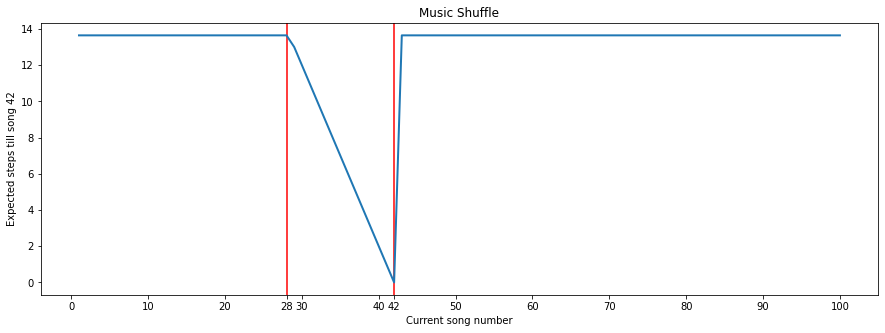

In [8]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.axvline(x=28, color="r")
plt.axvline(x=42, color="r")
plt.xticks(list(range(0,101,10)) + [28,42])
plt.xlabel('Current song number')
plt.ylabel('Expected steps till song 42')
plt.title("Music Shuffle")

# Plot results for all states
plt.plot(range(1,101), result.get_values()[1:], linewidth=2);

## Exploring the solution

**Question**: Which button should be pressed?

**Solution**: Obtain scheduler specifying the optimal choice


In [9]:
result = stormpy.model_checking(model, properties[0], extract_scheduler=True)
scheduler = result.scheduler
assert scheduler.memoryless
assert scheduler.deterministic

buttons = dict()
for state in model.states:
    choice = scheduler.get_choice(state)
    action = choice.get_deterministic_choice()
    buttons[state.id] = action
    
print(buttons)

{0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 0, 30: 0, 31: 0, 32: 0, 33: 0, 34: 0, 35: 0, 36: 0, 37: 0, 38: 0, 39: 0, 40: 0, 41: 0, 42: 0, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1, 100: 1}


In [10]:
for s, b in buttons.items():
    if s == 0: continue
    print("{}: {}".format(s, choice_labels.get_labels_of_choice(b+2*s+1)))

1: {'shuffle'}
2: {'shuffle'}
3: {'shuffle'}
4: {'shuffle'}
5: {'shuffle'}
6: {'shuffle'}
7: {'shuffle'}
8: {'shuffle'}
9: {'shuffle'}
10: {'shuffle'}
11: {'shuffle'}
12: {'shuffle'}
13: {'shuffle'}
14: {'shuffle'}
15: {'shuffle'}
16: {'shuffle'}
17: {'shuffle'}
18: {'shuffle'}
19: {'shuffle'}
20: {'shuffle'}
21: {'shuffle'}
22: {'shuffle'}
23: {'shuffle'}
24: {'shuffle'}
25: {'shuffle'}
26: {'shuffle'}
27: {'shuffle'}
28: {'shuffle'}
29: {'next'}
30: {'next'}
31: {'next'}
32: {'next'}
33: {'next'}
34: {'next'}
35: {'next'}
36: {'next'}
37: {'next'}
38: {'next'}
39: {'next'}
40: {'next'}
41: {'next'}
42: {'next'}
43: {'shuffle'}
44: {'shuffle'}
45: {'shuffle'}
46: {'shuffle'}
47: {'shuffle'}
48: {'shuffle'}
49: {'shuffle'}
50: {'shuffle'}
51: {'shuffle'}
52: {'shuffle'}
53: {'shuffle'}
54: {'shuffle'}
55: {'shuffle'}
56: {'shuffle'}
57: {'shuffle'}
58: {'shuffle'}
59: {'shuffle'}
60: {'shuffle'}
61: {'shuffle'}
62: {'shuffle'}
63: {'shuffle'}
64: {'shuffle'}
65: {'shuffle'}
66: {'shuff

## Exploring the solution

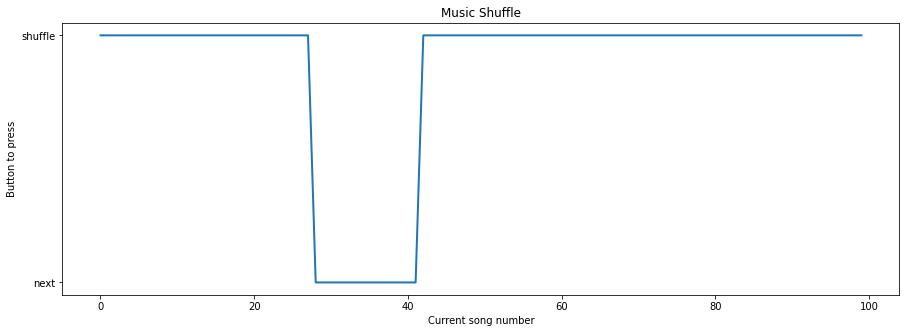

In [11]:
plt.xlabel('Current song number')
plt.ylabel('Button to press')
plt.title("Music Shuffle")
plt.yticks([0,1], ["next", "shuffle"])

button_list = [b for s, b in buttons.items()]

# Plot results for all states
plt.plot(button_list[1:], linewidth=2);

## Multiobjective model checking
Satisfy more than one objective:
1. Reach song 42 within 10 steps, and
2. Do not listen to the songs 1-10 before song 42 (for the first 10 steps)


## Multiobjective model checking

In [13]:
!storm --prism examples/music_shuffle.nm --prop 'multi(Pmax=? [F<=10 "found"], Pmin=? [!"found" U<=10 "avoid"])' --multiobjective:exportplot . | tail -1

Time for model checking: 1.318s.


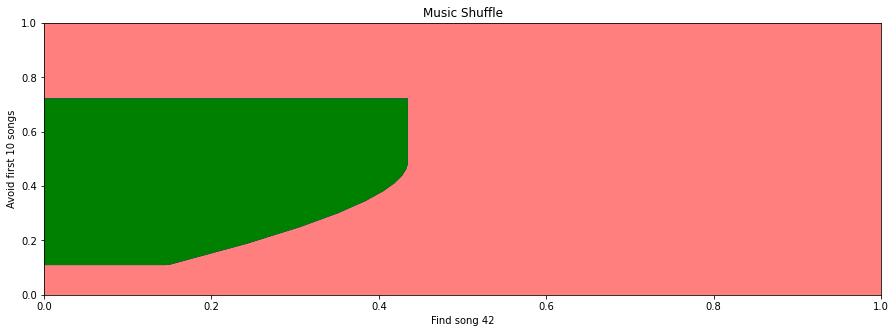

In [14]:
import numpy as np
from numpy import genfromtxt
overapprox = genfromtxt('overapproximation.csv', delimiter=',', skip_header=1)
underapprox = genfromtxt('underapproximation.csv', delimiter=',', skip_header=1)
boundaries = genfromtxt('paretopoints.csv', delimiter=',', skip_header=1)
import matplotlib.pyplot as plt
plt.margins(0)
plt.axis((0,1,0,1))
plt.xlabel('Find song 42')
plt.ylabel('Avoid first 10 songs')
plt.title("Music Shuffle")
plt.axhspan(0, 1, facecolor='r', alpha=0.5)
plt.fill(boundaries[:,0], boundaries[:,1], 'r', alpha=1)
plt.fill(overapprox[:,0], overapprox[:,1], 'b', alpha=1)
plt.fill(underapprox[:,0], underapprox[:,1], 'g', alpha=1);

## Parametric model checking
- Leave some probabilities open and use parameters instead


### Music shuffle 2:
- 20 songs
- Start at song 10
- Only one (probabilistic) button:
    - with probability *p* go to *next song*
    - with probability *1-p* go *two songs back*
- Want to listen to song 12

In [16]:
prism_program = stormpy.parse_prism_program("examples/music_shuffle2.nm")
properties = stormpy.parse_properties('Rmin=? [F "found"];Rmin=? [F "found2"]', prism_program)
model = stormpy.build_parametric_model(prism_program)

# Model checking
result = stormpy.model_checking(model, properties[0])
initial_state = model.initial_states[0]
ratfunc = str(result.at(initial_state))
print(ratfunc)

 WARN (FormulaParserGrammar.cpp:328): Identifier `R' coincides with a reserved keyword or operator. Property expressions using the variable or constant 'R' will not be parsed correctly.
(7*p^18+(-80)*p^3+(-125)*p^2+(-84)*p^17+336*p^16+(-308)*p^15+(-1505)*p^14+4816*p^13+(-3682)*p^12+(-6792)*p^11+18051*p^10+(-16400)*p^9+5034*p^8+972*p^7+1277*p^6+(-3136)*p^5+1610*p^4+10)/((p) * (p^2+(-2)*p+2) * (p^4+(-5)*p^3+15*p^2+(-15)*p+5) * (p^4+(-1)*p^3+p^2+(-1)*p+1) * (p^8+13*p^2+(-40)*p^3+71*p^4+(-60)*p^5+17*p^6+2*p^7+(-4)*p+1))


## Parametric model checking


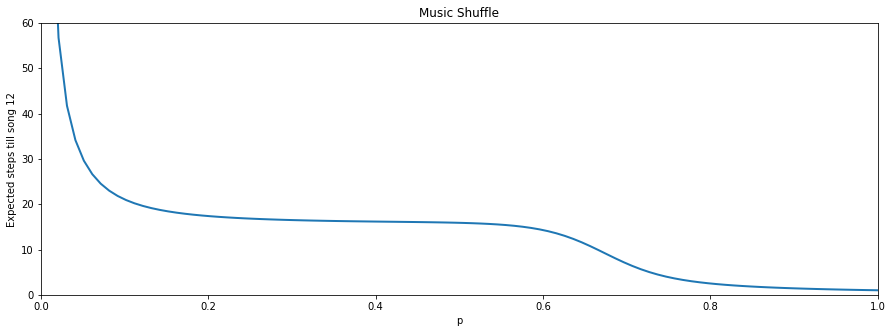

In [17]:
plt.xlabel('p')
plt.ylabel('Expected steps till song 12')
plt.title("Music Shuffle")

p = np.linspace(0.001, 0.999, 100)
plt.axis((0,1,0,60))
plot_func = eval(ratfunc.replace("^", "**"))
plt.plot(p, plot_func, linewidth=2);

## Parametric model checking
Reaching different songs

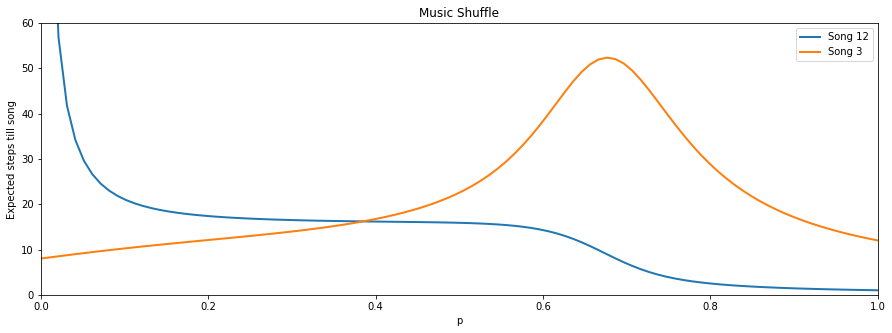

In [18]:
# Model checking for song 3
result2 = stormpy.model_checking(model, properties[1])
ratfunc2 = str(result2.at(initial_state))
plt.xlabel('p')
plt.ylabel('Expected steps till song')
plt.title("Music Shuffle")
p = np.linspace(0.001, 0.999, 100)
plt.axis((0,1,0,60))
plot_func2 = eval(ratfunc2.replace("^", "**"))
plt.plot(p, plot_func, label="Song 12", linewidth=2)
plt.plot(p, plot_func2, label="Song 3", linewidth=2)
plt.legend();

## Stormpy
- **Python** bindings for Storm
- **Easy and rapid** access to features of Storm
- Allows **user guided analysis**
- **Fast prototyping** of tools and approaches

## Summary

### Storm
- Is **efficient**
- **Modular** approach for solvers
- Specialized **engines**
- Broad range of **properties** (probabilities, expected rewards, multi-objective, ...)
- **Parametric analysis**
- and many more: Partially observable MDP, generalized stochastic Petri nets, dynamic fault trees, ...

### Try it out!
<br>
<center>
    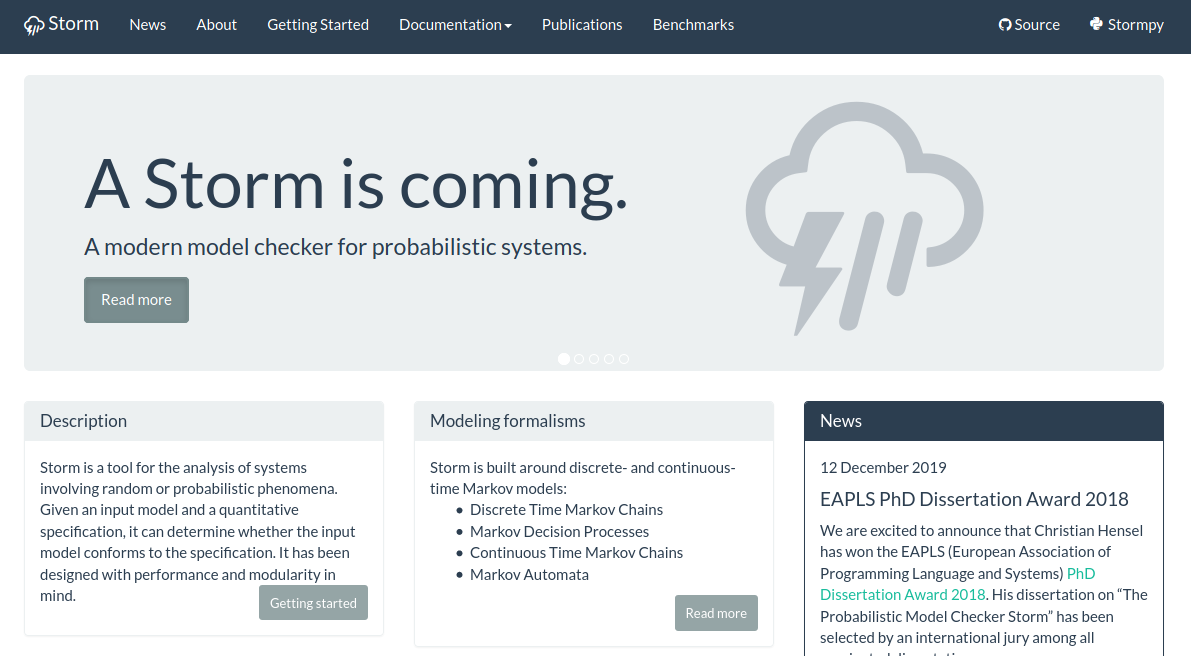
</center>

**<center>[www.stormchecker.org](https://www.stormchecker.org)</center>**